In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


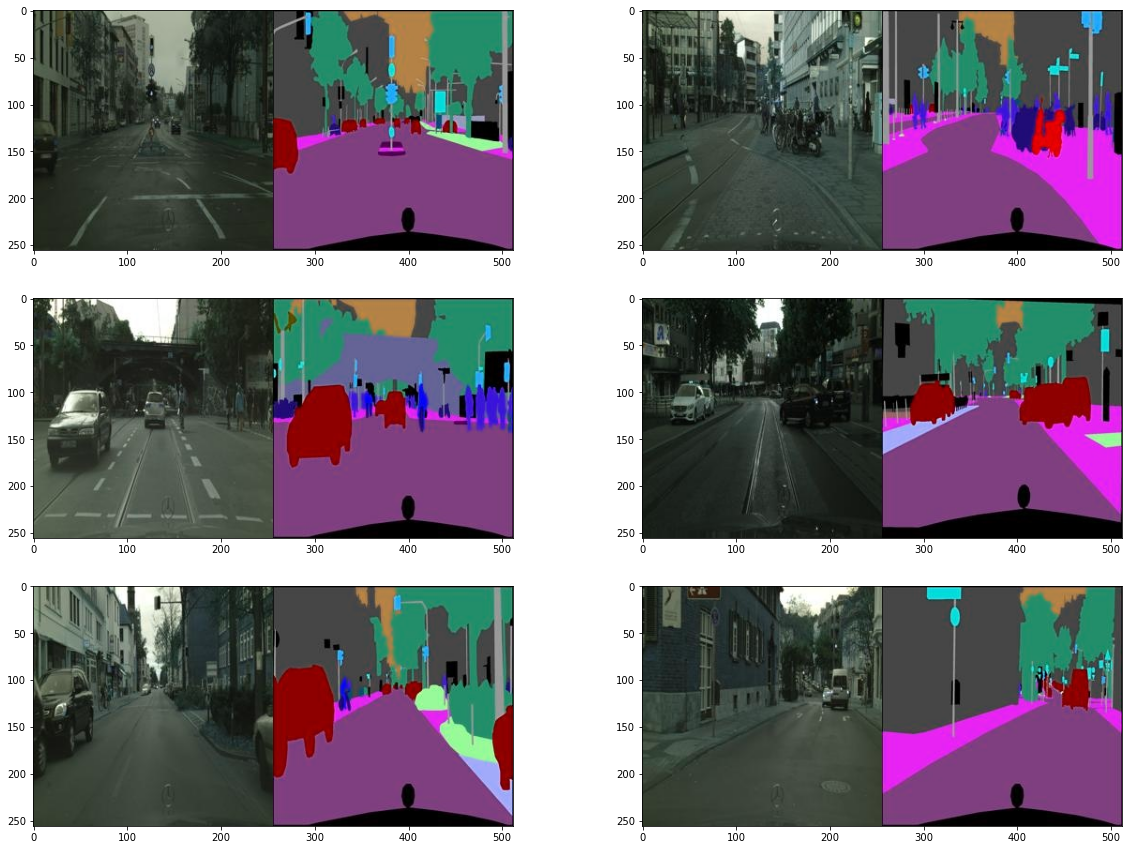

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

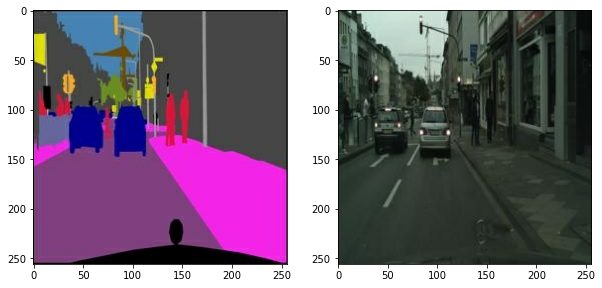

In [3]:
import tensorflow as tf

# def normalize(x):
#     x = tf.cast(x, tf.float32)
#     return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, 3)
    
    w = tf.shape(img)[1] // 2
    real_image = img[:, :w, :]
    input_image = img[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

f = data_path + os.listdir(data_path)[1]
inp, re = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(inp/255.0)
plt.subplot(1,2,2); plt.imshow(re/255.0)

In [4]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

def resize(input_image, real_image, height, width):
    print(input_image)
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image, real_image,IMG_HEIGHT=256,IMG_WIDTH=256):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(input_image, real_image):
    input_image, real_image = resize(input_image, real_image, 286, 286)
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    input_image, real_image = random_crop(input_image,real_image)
    
    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
        
    return input_image,real_image

print("✅")

✅


Tensor("input_image:0", shape=(256, 256, 3), dtype=float32)


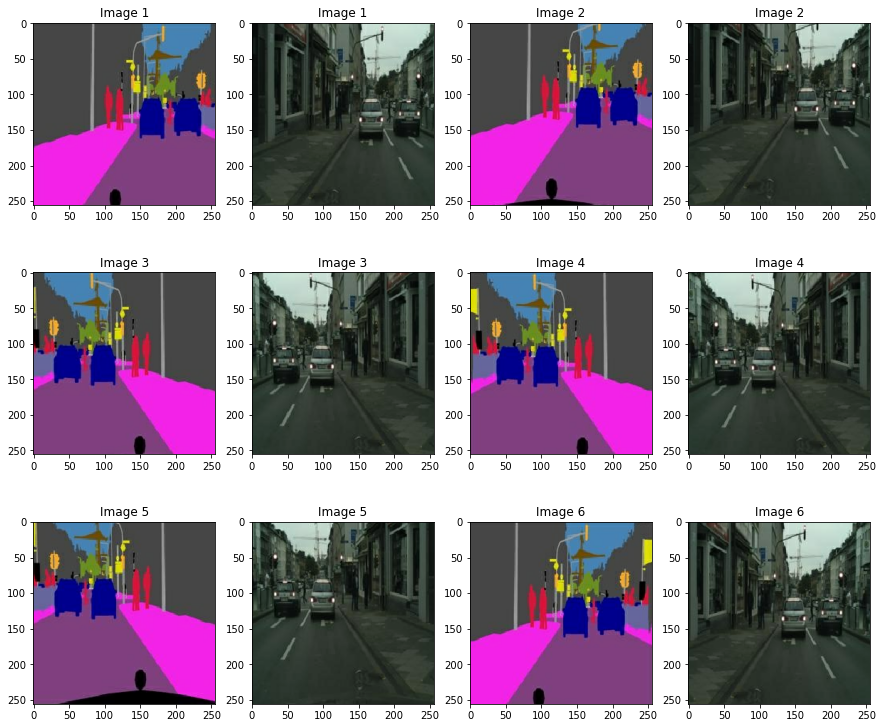

In [5]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_inp, augmented_re = apply_augmentation(inp, re)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_inp)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_re)); plt.title(f"Image {img_n}")
    img_n += 1

Tensor("input_image:0", shape=(None, None, 3), dtype=float32)


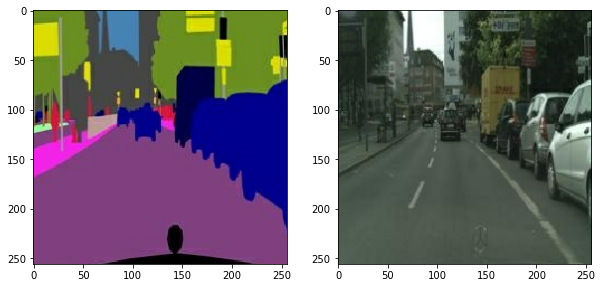

In [6]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

In [7]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [8]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [9]:
Encoder().get_summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)        

In [10]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [11]:
Decoder().get_summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)      

In [12]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


In [13]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [14]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [15]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [16]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_30 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [17]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [18]:
Discriminator().get_summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 6)  0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate[0][0]     

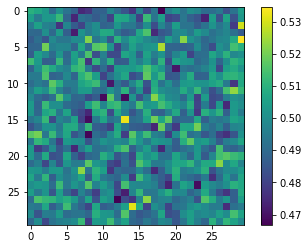

In [19]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [20]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [21]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [22]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [23]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9128                     
L1_loss:0.3086                     
Discriminator_loss:1.2275

EPOCH[1] - STEP[20]                     
Generator_loss:1.0959                     
L1_loss:0.2269                     
Discriminator_loss:1.1279

EPOCH[1] - STEP[30]                     
Generator_loss:1.1923                     
L1_loss:0.1987                     
Discriminator_loss:1.3380

EPOCH[1] - STEP[40]                     
Generator_loss:0.9806                     
L1_loss:0.1848                     
Discriminator_loss:1.2467

EPOCH[1] - STEP[50]                     
Generator_loss:0.8241                     
L1_loss:0.1655                     
Discriminator_loss:1.2296

EPOCH[1] - STEP[60]                     
Generator_loss:0.9490                     
L1_loss:0.2110                     
Discriminator_loss:0.8535

EPOCH[1] - STEP[70]                     
Generator_loss:1.2966                     
L1_loss:0.1627                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.4759                     
L1_loss:0.1909                     
Discriminator_loss:1.0214

EPOCH[3] - STEP[80]                     
Generator_loss:1.9820                     
L1_loss:0.2380                     
Discriminator_loss:0.2260

EPOCH[3] - STEP[90]                     
Generator_loss:1.4344                     
L1_loss:0.1577                     
Discriminator_loss:0.8168

EPOCH[3] - STEP[100]                     
Generator_loss:0.9393                     
L1_loss:0.2002                     
Discriminator_loss:0.7131

EPOCH[3] - STEP[110]                     
Generator_loss:2.7328                     
L1_loss:0.2074                     
Discriminator_loss:0.2248

EPOCH[3] - STEP[120]                     
Generator_loss:0.4146                     
L1_loss:0.1695                     
Discriminator_loss:1.8376

EPOCH[3] - STEP[130]                     
Generator_loss:2.3204                     
L1_loss:0.1703                

EPOCH[5] - STEP[130]                     
Generator_loss:1.4889                     
L1_loss:0.1550                     
Discriminator_loss:0.7608

EPOCH[5] - STEP[140]                     
Generator_loss:1.9235                     
L1_loss:0.1659                     
Discriminator_loss:0.7701

EPOCH[5] - STEP[150]                     
Generator_loss:0.7218                     
L1_loss:0.1644                     
Discriminator_loss:0.8138

EPOCH[5] - STEP[160]                     
Generator_loss:1.5070                     
L1_loss:0.1754                     
Discriminator_loss:0.6806

EPOCH[5] - STEP[170]                     
Generator_loss:1.1142                     
L1_loss:0.1900                     
Discriminator_loss:0.5753

EPOCH[5] - STEP[180]                     
Generator_loss:1.5732                     
L1_loss:0.1744                     
Discriminator_loss:1.2813

EPOCH[5] - STEP[190]                     
Generator_loss:2.2249                     
L1_loss:0.1785             

EPOCH[7] - STEP[190]                     
Generator_loss:1.2017                     
L1_loss:0.1784                     
Discriminator_loss:0.5208

EPOCH[7] - STEP[200]                     
Generator_loss:1.0121                     
L1_loss:0.1609                     
Discriminator_loss:0.7118

EPOCH[7] - STEP[210]                     
Generator_loss:1.3182                     
L1_loss:0.1917                     
Discriminator_loss:0.8424

EPOCH[7] - STEP[220]                     
Generator_loss:0.8239                     
L1_loss:0.2084                     
Discriminator_loss:1.0185

EPOCH[7] - STEP[230]                     
Generator_loss:0.1639                     
L1_loss:0.1804                     
Discriminator_loss:2.1595

EPOCH[7] - STEP[240]                     
Generator_loss:1.0147                     
L1_loss:0.1920                     
Discriminator_loss:0.6001

EPOCH[7] - STEP[250]                     
Generator_loss:1.0221                     
L1_loss:0.1905             

EPOCH[9] - STEP[250]                     
Generator_loss:1.2889                     
L1_loss:0.1743                     
Discriminator_loss:0.6292

EPOCH[10] - STEP[10]                     
Generator_loss:0.9756                     
L1_loss:0.1799                     
Discriminator_loss:0.6354

EPOCH[10] - STEP[20]                     
Generator_loss:1.3392                     
L1_loss:0.1701                     
Discriminator_loss:1.1553

EPOCH[10] - STEP[30]                     
Generator_loss:2.4434                     
L1_loss:0.1592                     
Discriminator_loss:0.7917

EPOCH[10] - STEP[40]                     
Generator_loss:1.0950                     
L1_loss:0.1891                     
Discriminator_loss:0.6403

EPOCH[10] - STEP[50]                     
Generator_loss:1.5839                     
L1_loss:0.1721                     
Discriminator_loss:0.6343

EPOCH[10] - STEP[60]                     
Generator_loss:1.8109                     
L1_loss:0.1754             

EPOCH[12] - STEP[60]                     
Generator_loss:0.9236                     
L1_loss:0.1988                     
Discriminator_loss:0.9789

EPOCH[12] - STEP[70]                     
Generator_loss:1.0475                     
L1_loss:0.1726                     
Discriminator_loss:0.6050

EPOCH[12] - STEP[80]                     
Generator_loss:1.8077                     
L1_loss:0.1927                     
Discriminator_loss:0.5400

EPOCH[12] - STEP[90]                     
Generator_loss:0.5280                     
L1_loss:0.2112                     
Discriminator_loss:0.9826

EPOCH[12] - STEP[100]                     
Generator_loss:1.3273                     
L1_loss:0.1802                     
Discriminator_loss:0.6210

EPOCH[12] - STEP[110]                     
Generator_loss:1.3133                     
L1_loss:0.1687                     
Discriminator_loss:2.1114

EPOCH[12] - STEP[120]                     
Generator_loss:1.5063                     
L1_loss:0.1360          

EPOCH[14] - STEP[120]                     
Generator_loss:3.2833                     
L1_loss:0.1557                     
Discriminator_loss:1.3905

EPOCH[14] - STEP[130]                     
Generator_loss:1.1870                     
L1_loss:0.1876                     
Discriminator_loss:0.4478

EPOCH[14] - STEP[140]                     
Generator_loss:0.7113                     
L1_loss:0.2019                     
Discriminator_loss:0.9676

EPOCH[14] - STEP[150]                     
Generator_loss:0.7697                     
L1_loss:0.1843                     
Discriminator_loss:1.0982

EPOCH[14] - STEP[160]                     
Generator_loss:1.6362                     
L1_loss:0.1708                     
Discriminator_loss:1.7346

EPOCH[14] - STEP[170]                     
Generator_loss:1.5708                     
L1_loss:0.1691                     
Discriminator_loss:1.1100

EPOCH[14] - STEP[180]                     
Generator_loss:2.4495                     
L1_loss:0.1797      

EPOCH[16] - STEP[180]                     
Generator_loss:2.0468                     
L1_loss:0.1743                     
Discriminator_loss:0.7828

EPOCH[16] - STEP[190]                     
Generator_loss:1.6614                     
L1_loss:0.1579                     
Discriminator_loss:0.4499

EPOCH[16] - STEP[200]                     
Generator_loss:0.8950                     
L1_loss:0.1985                     
Discriminator_loss:0.9670

EPOCH[16] - STEP[210]                     
Generator_loss:0.6680                     
L1_loss:0.2050                     
Discriminator_loss:0.9486

EPOCH[16] - STEP[220]                     
Generator_loss:1.9067                     
L1_loss:0.1696                     
Discriminator_loss:1.3066

EPOCH[16] - STEP[230]                     
Generator_loss:1.7265                     
L1_loss:0.1659                     
Discriminator_loss:0.8121

EPOCH[16] - STEP[240]                     
Generator_loss:1.8370                     
L1_loss:0.1590      

EPOCH[18] - STEP[240]                     
Generator_loss:1.2687                     
L1_loss:0.1607                     
Discriminator_loss:1.3612

EPOCH[18] - STEP[250]                     
Generator_loss:0.8726                     
L1_loss:0.2193                     
Discriminator_loss:0.7284

EPOCH[19] - STEP[10]                     
Generator_loss:1.0488                     
L1_loss:0.2044                     
Discriminator_loss:0.5227

EPOCH[19] - STEP[20]                     
Generator_loss:2.0504                     
L1_loss:0.1596                     
Discriminator_loss:1.2684

EPOCH[19] - STEP[30]                     
Generator_loss:2.3511                     
L1_loss:0.1573                     
Discriminator_loss:0.7813

EPOCH[19] - STEP[40]                     
Generator_loss:1.4054                     
L1_loss:0.1598                     
Discriminator_loss:1.0947

EPOCH[19] - STEP[50]                     
Generator_loss:0.8896                     
L1_loss:0.2027           

EPOCH[21] - STEP[50]                     
Generator_loss:1.1471                     
L1_loss:0.1700                     
Discriminator_loss:0.6029

EPOCH[21] - STEP[60]                     
Generator_loss:1.2779                     
L1_loss:0.1942                     
Discriminator_loss:0.5657

EPOCH[21] - STEP[70]                     
Generator_loss:1.6774                     
L1_loss:0.1840                     
Discriminator_loss:0.3913

EPOCH[21] - STEP[80]                     
Generator_loss:2.0129                     
L1_loss:0.1939                     
Discriminator_loss:1.2014

EPOCH[21] - STEP[90]                     
Generator_loss:2.3316                     
L1_loss:0.2141                     
Discriminator_loss:0.3781

EPOCH[21] - STEP[100]                     
Generator_loss:2.2555                     
L1_loss:0.1724                     
Discriminator_loss:0.7971

EPOCH[21] - STEP[110]                     
Generator_loss:0.4414                     
L1_loss:0.1861           

EPOCH[23] - STEP[110]                     
Generator_loss:1.3773                     
L1_loss:0.1616                     
Discriminator_loss:1.2804

EPOCH[23] - STEP[120]                     
Generator_loss:1.1037                     
L1_loss:0.1658                     
Discriminator_loss:1.6388

EPOCH[23] - STEP[130]                     
Generator_loss:0.9547                     
L1_loss:0.1833                     
Discriminator_loss:0.6068

EPOCH[23] - STEP[140]                     
Generator_loss:0.9067                     
L1_loss:0.1911                     
Discriminator_loss:0.6482

EPOCH[23] - STEP[150]                     
Generator_loss:1.5589                     
L1_loss:0.1608                     
Discriminator_loss:1.1370

EPOCH[23] - STEP[160]                     
Generator_loss:1.5082                     
L1_loss:0.1553                     
Discriminator_loss:0.3787

EPOCH[23] - STEP[170]                     
Generator_loss:2.1459                     
L1_loss:0.1654      

EPOCH[25] - STEP[170]                     
Generator_loss:0.4016                     
L1_loss:0.1744                     
Discriminator_loss:1.5612

EPOCH[25] - STEP[180]                     
Generator_loss:1.8235                     
L1_loss:0.1881                     
Discriminator_loss:0.2531

EPOCH[25] - STEP[190]                     
Generator_loss:1.7163                     
L1_loss:0.1869                     
Discriminator_loss:1.0502

EPOCH[25] - STEP[200]                     
Generator_loss:1.6810                     
L1_loss:0.1752                     
Discriminator_loss:0.4639

EPOCH[25] - STEP[210]                     
Generator_loss:1.8313                     
L1_loss:0.1688                     
Discriminator_loss:1.3732

EPOCH[25] - STEP[220]                     
Generator_loss:0.9800                     
L1_loss:0.1653                     
Discriminator_loss:0.8974

EPOCH[25] - STEP[230]                     
Generator_loss:1.6971                     
L1_loss:0.1702      

EPOCH[27] - STEP[230]                     
Generator_loss:0.7614                     
L1_loss:0.2053                     
Discriminator_loss:0.7782

EPOCH[27] - STEP[240]                     
Generator_loss:1.0607                     
L1_loss:0.1673                     
Discriminator_loss:0.9787

EPOCH[27] - STEP[250]                     
Generator_loss:1.6756                     
L1_loss:0.1531                     
Discriminator_loss:1.2742

EPOCH[28] - STEP[10]                     
Generator_loss:0.7014                     
L1_loss:0.1760                     
Discriminator_loss:0.9488

EPOCH[28] - STEP[20]                     
Generator_loss:1.2143                     
L1_loss:0.1899                     
Discriminator_loss:0.4745

EPOCH[28] - STEP[30]                     
Generator_loss:1.0021                     
L1_loss:0.1877                     
Discriminator_loss:0.7567

EPOCH[28] - STEP[40]                     
Generator_loss:1.2441                     
L1_loss:0.1984          

EPOCH[30] - STEP[40]                     
Generator_loss:1.1843                     
L1_loss:0.1542                     
Discriminator_loss:1.5632

EPOCH[30] - STEP[50]                     
Generator_loss:1.4436                     
L1_loss:0.1672                     
Discriminator_loss:0.4879

EPOCH[30] - STEP[60]                     
Generator_loss:1.6519                     
L1_loss:0.1607                     
Discriminator_loss:1.1672

EPOCH[30] - STEP[70]                     
Generator_loss:1.6779                     
L1_loss:0.1790                     
Discriminator_loss:0.6958

EPOCH[30] - STEP[80]                     
Generator_loss:0.8263                     
L1_loss:0.2102                     
Discriminator_loss:0.7155

EPOCH[30] - STEP[90]                     
Generator_loss:0.9260                     
L1_loss:0.1840                     
Discriminator_loss:0.7221

EPOCH[30] - STEP[100]                     
Generator_loss:2.1533                     
L1_loss:0.1719            

EPOCH[32] - STEP[100]                     
Generator_loss:1.8527                     
L1_loss:0.1973                     
Discriminator_loss:0.2111

EPOCH[32] - STEP[110]                     
Generator_loss:2.5209                     
L1_loss:0.1937                     
Discriminator_loss:0.1618

EPOCH[32] - STEP[120]                     
Generator_loss:1.8339                     
L1_loss:0.1530                     
Discriminator_loss:2.1270

EPOCH[32] - STEP[130]                     
Generator_loss:1.7087                     
L1_loss:0.1904                     
Discriminator_loss:0.7414

EPOCH[32] - STEP[140]                     
Generator_loss:0.8772                     
L1_loss:0.1679                     
Discriminator_loss:0.8867

EPOCH[32] - STEP[150]                     
Generator_loss:2.2239                     
L1_loss:0.1701                     
Discriminator_loss:1.1190

EPOCH[32] - STEP[160]                     
Generator_loss:2.0564                     
L1_loss:0.1732      

EPOCH[34] - STEP[160]                     
Generator_loss:1.9192                     
L1_loss:0.2133                     
Discriminator_loss:0.2054

EPOCH[34] - STEP[170]                     
Generator_loss:1.0905                     
L1_loss:0.1592                     
Discriminator_loss:0.6239

EPOCH[34] - STEP[180]                     
Generator_loss:1.5335                     
L1_loss:0.1700                     
Discriminator_loss:0.4578

EPOCH[34] - STEP[190]                     
Generator_loss:1.0171                     
L1_loss:0.1680                     
Discriminator_loss:0.5846

EPOCH[34] - STEP[200]                     
Generator_loss:0.9795                     
L1_loss:0.1894                     
Discriminator_loss:0.9669

EPOCH[34] - STEP[210]                     
Generator_loss:1.5606                     
L1_loss:0.1587                     
Discriminator_loss:1.4576

EPOCH[34] - STEP[220]                     
Generator_loss:1.5666                     
L1_loss:0.1782      

EPOCH[36] - STEP[220]                     
Generator_loss:1.5738                     
L1_loss:0.1515                     
Discriminator_loss:1.6071

EPOCH[36] - STEP[230]                     
Generator_loss:1.0663                     
L1_loss:0.1464                     
Discriminator_loss:0.9536

EPOCH[36] - STEP[240]                     
Generator_loss:1.3702                     
L1_loss:0.1822                     
Discriminator_loss:0.3939

EPOCH[36] - STEP[250]                     
Generator_loss:0.9193                     
L1_loss:0.1811                     
Discriminator_loss:0.6391

EPOCH[37] - STEP[10]                     
Generator_loss:1.4399                     
L1_loss:0.1949                     
Discriminator_loss:0.4228

EPOCH[37] - STEP[20]                     
Generator_loss:2.5119                     
L1_loss:0.1812                     
Discriminator_loss:1.8040

EPOCH[37] - STEP[30]                     
Generator_loss:2.2126                     
L1_loss:0.1456         

EPOCH[39] - STEP[30]                     
Generator_loss:1.7721                     
L1_loss:0.1588                     
Discriminator_loss:0.3709

EPOCH[39] - STEP[40]                     
Generator_loss:1.5901                     
L1_loss:0.1675                     
Discriminator_loss:2.0848

EPOCH[39] - STEP[50]                     
Generator_loss:1.4338                     
L1_loss:0.1792                     
Discriminator_loss:0.6808

EPOCH[39] - STEP[60]                     
Generator_loss:0.8099                     
L1_loss:0.2262                     
Discriminator_loss:0.7232

EPOCH[39] - STEP[70]                     
Generator_loss:1.4649                     
L1_loss:0.1650                     
Discriminator_loss:0.8780

EPOCH[39] - STEP[80]                     
Generator_loss:1.3898                     
L1_loss:0.1495                     
Discriminator_loss:0.8633

EPOCH[39] - STEP[90]                     
Generator_loss:0.6920                     
L1_loss:0.1791             

EPOCH[41] - STEP[90]                     
Generator_loss:0.2129                     
L1_loss:0.1887                     
Discriminator_loss:1.9111

EPOCH[41] - STEP[100]                     
Generator_loss:1.2060                     
L1_loss:0.1682                     
Discriminator_loss:0.5814

EPOCH[41] - STEP[110]                     
Generator_loss:0.6336                     
L1_loss:0.1665                     
Discriminator_loss:1.0281

EPOCH[41] - STEP[120]                     
Generator_loss:0.7554                     
L1_loss:0.1536                     
Discriminator_loss:1.1430

EPOCH[41] - STEP[130]                     
Generator_loss:1.5027                     
L1_loss:0.1903                     
Discriminator_loss:0.4447

EPOCH[41] - STEP[140]                     
Generator_loss:1.1793                     
L1_loss:0.2110                     
Discriminator_loss:0.4491

EPOCH[41] - STEP[150]                     
Generator_loss:0.2898                     
L1_loss:0.1699       

EPOCH[43] - STEP[150]                     
Generator_loss:1.5149                     
L1_loss:0.1658                     
Discriminator_loss:1.0634

EPOCH[43] - STEP[160]                     
Generator_loss:1.2617                     
L1_loss:0.1654                     
Discriminator_loss:0.5433

EPOCH[43] - STEP[170]                     
Generator_loss:0.9539                     
L1_loss:0.1452                     
Discriminator_loss:0.9545

EPOCH[43] - STEP[180]                     
Generator_loss:2.0836                     
L1_loss:0.1751                     
Discriminator_loss:0.2093

EPOCH[43] - STEP[190]                     
Generator_loss:1.0495                     
L1_loss:0.1649                     
Discriminator_loss:1.2480

EPOCH[43] - STEP[200]                     
Generator_loss:0.5962                     
L1_loss:0.1856                     
Discriminator_loss:1.1079

EPOCH[43] - STEP[210]                     
Generator_loss:0.4143                     
L1_loss:0.1479      

EPOCH[45] - STEP[210]                     
Generator_loss:1.6544                     
L1_loss:0.1625                     
Discriminator_loss:0.4804

EPOCH[45] - STEP[220]                     
Generator_loss:2.6490                     
L1_loss:0.1682                     
Discriminator_loss:0.8830

EPOCH[45] - STEP[230]                     
Generator_loss:1.9144                     
L1_loss:0.1779                     
Discriminator_loss:2.7380

EPOCH[45] - STEP[240]                     
Generator_loss:1.8398                     
L1_loss:0.1649                     
Discriminator_loss:0.6332

EPOCH[45] - STEP[250]                     
Generator_loss:2.3591                     
L1_loss:0.1644                     
Discriminator_loss:0.8701

EPOCH[46] - STEP[10]                     
Generator_loss:0.6900                     
L1_loss:0.1568                     
Discriminator_loss:1.1642

EPOCH[46] - STEP[20]                     
Generator_loss:2.3403                     
L1_loss:0.1665        

EPOCH[48] - STEP[20]                     
Generator_loss:1.3066                     
L1_loss:0.1637                     
Discriminator_loss:1.2923

EPOCH[48] - STEP[30]                     
Generator_loss:1.9458                     
L1_loss:0.1968                     
Discriminator_loss:0.3076

EPOCH[48] - STEP[40]                     
Generator_loss:1.6041                     
L1_loss:0.1532                     
Discriminator_loss:0.9198

EPOCH[48] - STEP[50]                     
Generator_loss:1.4133                     
L1_loss:0.1815                     
Discriminator_loss:0.5123

EPOCH[48] - STEP[60]                     
Generator_loss:0.8786                     
L1_loss:0.1867                     
Discriminator_loss:0.6845

EPOCH[48] - STEP[70]                     
Generator_loss:1.4916                     
L1_loss:0.1962                     
Discriminator_loss:0.7175

EPOCH[48] - STEP[80]                     
Generator_loss:2.0173                     
L1_loss:0.1520             

EPOCH[50] - STEP[80]                     
Generator_loss:1.5066                     
L1_loss:0.1732                     
Discriminator_loss:0.3775

EPOCH[50] - STEP[90]                     
Generator_loss:1.4470                     
L1_loss:0.1629                     
Discriminator_loss:0.9641

EPOCH[50] - STEP[100]                     
Generator_loss:0.3646                     
L1_loss:0.1376                     
Discriminator_loss:1.8010

EPOCH[50] - STEP[110]                     
Generator_loss:1.0396                     
L1_loss:0.1914                     
Discriminator_loss:0.5365

EPOCH[50] - STEP[120]                     
Generator_loss:1.8733                     
L1_loss:0.1628                     
Discriminator_loss:0.6813

EPOCH[50] - STEP[130]                     
Generator_loss:2.0556                     
L1_loss:0.1483                     
Discriminator_loss:1.3850

EPOCH[50] - STEP[140]                     
Generator_loss:2.2243                     
L1_loss:0.1834        

EPOCH[52] - STEP[140]                     
Generator_loss:0.8243                     
L1_loss:0.1505                     
Discriminator_loss:2.1866

EPOCH[52] - STEP[150]                     
Generator_loss:1.9419                     
L1_loss:0.1701                     
Discriminator_loss:0.7950

EPOCH[52] - STEP[160]                     
Generator_loss:2.2403                     
L1_loss:0.1680                     
Discriminator_loss:2.0773

EPOCH[52] - STEP[170]                     
Generator_loss:0.9577                     
L1_loss:0.1442                     
Discriminator_loss:1.0994

EPOCH[52] - STEP[180]                     
Generator_loss:1.1793                     
L1_loss:0.1733                     
Discriminator_loss:0.5618

EPOCH[52] - STEP[190]                     
Generator_loss:2.6047                     
L1_loss:0.2162                     
Discriminator_loss:0.1103

EPOCH[52] - STEP[200]                     
Generator_loss:1.8849                     
L1_loss:0.1816      

EPOCH[54] - STEP[200]                     
Generator_loss:1.0845                     
L1_loss:0.1306                     
Discriminator_loss:1.1815

EPOCH[54] - STEP[210]                     
Generator_loss:0.4856                     
L1_loss:0.1687                     
Discriminator_loss:1.5166

EPOCH[54] - STEP[220]                     
Generator_loss:0.9817                     
L1_loss:0.1651                     
Discriminator_loss:0.6613

EPOCH[54] - STEP[230]                     
Generator_loss:1.1615                     
L1_loss:0.1505                     
Discriminator_loss:1.0628

EPOCH[54] - STEP[240]                     
Generator_loss:1.9836                     
L1_loss:0.1682                     
Discriminator_loss:1.0708

EPOCH[54] - STEP[250]                     
Generator_loss:1.3868                     
L1_loss:0.1472                     
Discriminator_loss:1.0708

EPOCH[55] - STEP[10]                     
Generator_loss:2.1512                     
L1_loss:0.1806       

EPOCH[57] - STEP[10]                     
Generator_loss:2.2240                     
L1_loss:0.1677                     
Discriminator_loss:1.6083

EPOCH[57] - STEP[20]                     
Generator_loss:1.8692                     
L1_loss:0.1709                     
Discriminator_loss:0.7830

EPOCH[57] - STEP[30]                     
Generator_loss:1.3363                     
L1_loss:0.1587                     
Discriminator_loss:1.5558

EPOCH[57] - STEP[40]                     
Generator_loss:0.5526                     
L1_loss:0.1558                     
Discriminator_loss:1.6828

EPOCH[57] - STEP[50]                     
Generator_loss:0.6787                     
L1_loss:0.1431                     
Discriminator_loss:1.9142

EPOCH[57] - STEP[60]                     
Generator_loss:1.7840                     
L1_loss:0.1647                     
Discriminator_loss:0.4427

EPOCH[57] - STEP[70]                     
Generator_loss:2.3459                     
L1_loss:0.1566             

EPOCH[59] - STEP[70]                     
Generator_loss:0.6081                     
L1_loss:0.1783                     
Discriminator_loss:1.0247

EPOCH[59] - STEP[80]                     
Generator_loss:1.6200                     
L1_loss:0.1755                     
Discriminator_loss:0.6580

EPOCH[59] - STEP[90]                     
Generator_loss:1.9230                     
L1_loss:0.1647                     
Discriminator_loss:0.9486

EPOCH[59] - STEP[100]                     
Generator_loss:0.6773                     
L1_loss:0.1875                     
Discriminator_loss:0.8702

EPOCH[59] - STEP[110]                     
Generator_loss:2.1241                     
L1_loss:0.1792                     
Discriminator_loss:0.5606

EPOCH[59] - STEP[120]                     
Generator_loss:0.8369                     
L1_loss:0.1691                     
Discriminator_loss:1.6836

EPOCH[59] - STEP[130]                     
Generator_loss:1.5249                     
L1_loss:0.1543         

EPOCH[61] - STEP[130]                     
Generator_loss:2.2543                     
L1_loss:0.1691                     
Discriminator_loss:0.8558

EPOCH[61] - STEP[140]                     
Generator_loss:2.9929                     
L1_loss:0.1902                     
Discriminator_loss:0.2241

EPOCH[61] - STEP[150]                     
Generator_loss:0.7660                     
L1_loss:0.1862                     
Discriminator_loss:0.7843

EPOCH[61] - STEP[160]                     
Generator_loss:1.7362                     
L1_loss:0.1434                     
Discriminator_loss:1.3074

EPOCH[61] - STEP[170]                     
Generator_loss:0.8115                     
L1_loss:0.1741                     
Discriminator_loss:0.7845

EPOCH[61] - STEP[180]                     
Generator_loss:0.9195                     
L1_loss:0.1450                     
Discriminator_loss:1.7349

EPOCH[61] - STEP[190]                     
Generator_loss:0.8615                     
L1_loss:0.1484      

EPOCH[63] - STEP[190]                     
Generator_loss:1.4089                     
L1_loss:0.1970                     
Discriminator_loss:0.3755

EPOCH[63] - STEP[200]                     
Generator_loss:0.8541                     
L1_loss:0.1964                     
Discriminator_loss:0.6404

EPOCH[63] - STEP[210]                     
Generator_loss:1.1538                     
L1_loss:0.1508                     
Discriminator_loss:0.7701

EPOCH[63] - STEP[220]                     
Generator_loss:2.0465                     
L1_loss:0.1612                     
Discriminator_loss:0.3330

EPOCH[63] - STEP[230]                     
Generator_loss:1.6920                     
L1_loss:0.1544                     
Discriminator_loss:1.4994

EPOCH[63] - STEP[240]                     
Generator_loss:0.9108                     
L1_loss:0.1557                     
Discriminator_loss:0.8698

EPOCH[63] - STEP[250]                     
Generator_loss:1.4028                     
L1_loss:0.1540      

EPOCH[65] - STEP[250]                     
Generator_loss:0.8365                     
L1_loss:0.1546                     
Discriminator_loss:0.9565

EPOCH[66] - STEP[10]                     
Generator_loss:0.5289                     
L1_loss:0.1660                     
Discriminator_loss:1.4449

EPOCH[66] - STEP[20]                     
Generator_loss:1.0876                     
L1_loss:0.1563                     
Discriminator_loss:1.0415

EPOCH[66] - STEP[30]                     
Generator_loss:0.6048                     
L1_loss:0.1562                     
Discriminator_loss:0.9529

EPOCH[66] - STEP[40]                     
Generator_loss:1.3136                     
L1_loss:0.1699                     
Discriminator_loss:0.5801

EPOCH[66] - STEP[50]                     
Generator_loss:1.0383                     
L1_loss:0.1507                     
Discriminator_loss:0.7226

EPOCH[66] - STEP[60]                     
Generator_loss:1.0463                     
L1_loss:0.1898            

EPOCH[68] - STEP[60]                     
Generator_loss:1.6864                     
L1_loss:0.1528                     
Discriminator_loss:0.5709

EPOCH[68] - STEP[70]                     
Generator_loss:2.3344                     
L1_loss:0.1752                     
Discriminator_loss:0.1972

EPOCH[68] - STEP[80]                     
Generator_loss:1.9618                     
L1_loss:0.1742                     
Discriminator_loss:0.2201

EPOCH[68] - STEP[90]                     
Generator_loss:1.3488                     
L1_loss:0.1747                     
Discriminator_loss:0.4696

EPOCH[68] - STEP[100]                     
Generator_loss:0.4357                     
L1_loss:0.1685                     
Discriminator_loss:1.2765

EPOCH[68] - STEP[110]                     
Generator_loss:0.9621                     
L1_loss:0.1536                     
Discriminator_loss:1.1501

EPOCH[68] - STEP[120]                     
Generator_loss:0.5346                     
L1_loss:0.1589          

EPOCH[70] - STEP[120]                     
Generator_loss:1.0135                     
L1_loss:0.1892                     
Discriminator_loss:0.5763

EPOCH[70] - STEP[130]                     
Generator_loss:1.2297                     
L1_loss:0.1706                     
Discriminator_loss:0.6763

EPOCH[70] - STEP[140]                     
Generator_loss:1.3541                     
L1_loss:0.1535                     
Discriminator_loss:1.0776

EPOCH[70] - STEP[150]                     
Generator_loss:1.2415                     
L1_loss:0.1745                     
Discriminator_loss:0.4718

EPOCH[70] - STEP[160]                     
Generator_loss:1.6793                     
L1_loss:0.1651                     
Discriminator_loss:0.3278

EPOCH[70] - STEP[170]                     
Generator_loss:1.6967                     
L1_loss:0.1850                     
Discriminator_loss:0.9578

EPOCH[70] - STEP[180]                     
Generator_loss:0.9091                     
L1_loss:0.1526      

EPOCH[72] - STEP[180]                     
Generator_loss:1.3268                     
L1_loss:0.1826                     
Discriminator_loss:0.8733

EPOCH[72] - STEP[190]                     
Generator_loss:2.6236                     
L1_loss:0.1578                     
Discriminator_loss:1.4285

EPOCH[72] - STEP[200]                     
Generator_loss:1.4410                     
L1_loss:0.1453                     
Discriminator_loss:1.2451

EPOCH[72] - STEP[210]                     
Generator_loss:1.6632                     
L1_loss:0.1328                     
Discriminator_loss:1.0919

EPOCH[72] - STEP[220]                     
Generator_loss:2.7100                     
L1_loss:0.1651                     
Discriminator_loss:1.0561

EPOCH[72] - STEP[230]                     
Generator_loss:1.5091                     
L1_loss:0.1640                     
Discriminator_loss:0.5354

EPOCH[72] - STEP[240]                     
Generator_loss:1.0036                     
L1_loss:0.1508      

EPOCH[74] - STEP[240]                     
Generator_loss:1.4884                     
L1_loss:0.1698                     
Discriminator_loss:0.6136

EPOCH[74] - STEP[250]                     
Generator_loss:1.5273                     
L1_loss:0.1427                     
Discriminator_loss:1.0301

EPOCH[75] - STEP[10]                     
Generator_loss:2.0845                     
L1_loss:0.1365                     
Discriminator_loss:0.7985

EPOCH[75] - STEP[20]                     
Generator_loss:1.3717                     
L1_loss:0.1627                     
Discriminator_loss:0.6070

EPOCH[75] - STEP[30]                     
Generator_loss:2.6035                     
L1_loss:0.1514                     
Discriminator_loss:1.6387

EPOCH[75] - STEP[40]                     
Generator_loss:0.4902                     
L1_loss:0.1567                     
Discriminator_loss:1.2823

EPOCH[75] - STEP[50]                     
Generator_loss:1.0189                     
L1_loss:0.1595           

EPOCH[77] - STEP[50]                     
Generator_loss:1.9679                     
L1_loss:0.1470                     
Discriminator_loss:1.1777

EPOCH[77] - STEP[60]                     
Generator_loss:1.8798                     
L1_loss:0.1527                     
Discriminator_loss:0.3471

EPOCH[77] - STEP[70]                     
Generator_loss:1.3792                     
L1_loss:0.1737                     
Discriminator_loss:0.5140

EPOCH[77] - STEP[80]                     
Generator_loss:0.3145                     
L1_loss:0.1735                     
Discriminator_loss:1.6740

EPOCH[77] - STEP[90]                     
Generator_loss:1.0912                     
L1_loss:0.1716                     
Discriminator_loss:0.7362

EPOCH[77] - STEP[100]                     
Generator_loss:0.8484                     
L1_loss:0.1465                     
Discriminator_loss:0.8605

EPOCH[77] - STEP[110]                     
Generator_loss:1.1204                     
L1_loss:0.1502           

EPOCH[79] - STEP[110]                     
Generator_loss:0.9731                     
L1_loss:0.1543                     
Discriminator_loss:0.9238

EPOCH[79] - STEP[120]                     
Generator_loss:2.3652                     
L1_loss:0.1428                     
Discriminator_loss:0.9414

EPOCH[79] - STEP[130]                     
Generator_loss:1.2760                     
L1_loss:0.1726                     
Discriminator_loss:0.5384

EPOCH[79] - STEP[140]                     
Generator_loss:0.7495                     
L1_loss:0.1695                     
Discriminator_loss:1.1063

EPOCH[79] - STEP[150]                     
Generator_loss:0.9032                     
L1_loss:0.1583                     
Discriminator_loss:0.8732

EPOCH[79] - STEP[160]                     
Generator_loss:1.2188                     
L1_loss:0.1641                     
Discriminator_loss:0.4568

EPOCH[79] - STEP[170]                     
Generator_loss:1.4153                     
L1_loss:0.1676      

EPOCH[81] - STEP[170]                     
Generator_loss:1.6552                     
L1_loss:0.1647                     
Discriminator_loss:0.9134

EPOCH[81] - STEP[180]                     
Generator_loss:1.5450                     
L1_loss:0.1402                     
Discriminator_loss:1.1825

EPOCH[81] - STEP[190]                     
Generator_loss:1.0209                     
L1_loss:0.1519                     
Discriminator_loss:0.7003

EPOCH[81] - STEP[200]                     
Generator_loss:1.1089                     
L1_loss:0.1674                     
Discriminator_loss:0.9596

EPOCH[81] - STEP[210]                     
Generator_loss:1.2622                     
L1_loss:0.1855                     
Discriminator_loss:0.5352

EPOCH[81] - STEP[220]                     
Generator_loss:0.4062                     
L1_loss:0.1517                     
Discriminator_loss:1.5328

EPOCH[81] - STEP[230]                     
Generator_loss:0.9370                     
L1_loss:0.1705      

EPOCH[83] - STEP[230]                     
Generator_loss:0.8148                     
L1_loss:0.1497                     
Discriminator_loss:1.0402

EPOCH[83] - STEP[240]                     
Generator_loss:2.0847                     
L1_loss:0.1614                     
Discriminator_loss:0.2689

EPOCH[83] - STEP[250]                     
Generator_loss:1.7495                     
L1_loss:0.1546                     
Discriminator_loss:0.4435

EPOCH[84] - STEP[10]                     
Generator_loss:1.8362                     
L1_loss:0.1664                     
Discriminator_loss:0.6583

EPOCH[84] - STEP[20]                     
Generator_loss:1.7686                     
L1_loss:0.1485                     
Discriminator_loss:1.0790

EPOCH[84] - STEP[30]                     
Generator_loss:0.8396                     
L1_loss:0.1628                     
Discriminator_loss:0.7736

EPOCH[84] - STEP[40]                     
Generator_loss:1.7381                     
L1_loss:0.1420          

EPOCH[86] - STEP[40]                     
Generator_loss:0.5998                     
L1_loss:0.1816                     
Discriminator_loss:1.0039

EPOCH[86] - STEP[50]                     
Generator_loss:0.5889                     
L1_loss:0.1231                     
Discriminator_loss:1.5727

EPOCH[86] - STEP[60]                     
Generator_loss:2.1802                     
L1_loss:0.1865                     
Discriminator_loss:0.2176

EPOCH[86] - STEP[70]                     
Generator_loss:2.2334                     
L1_loss:0.1496                     
Discriminator_loss:1.3100

EPOCH[86] - STEP[80]                     
Generator_loss:1.5068                     
L1_loss:0.1476                     
Discriminator_loss:0.7257

EPOCH[86] - STEP[90]                     
Generator_loss:0.8356                     
L1_loss:0.1563                     
Discriminator_loss:0.7541

EPOCH[86] - STEP[100]                     
Generator_loss:1.6687                     
L1_loss:0.1491            

EPOCH[88] - STEP[100]                     
Generator_loss:2.0731                     
L1_loss:0.1602                     
Discriminator_loss:0.3588

EPOCH[88] - STEP[110]                     
Generator_loss:0.6537                     
L1_loss:0.1495                     
Discriminator_loss:1.1834

EPOCH[88] - STEP[120]                     
Generator_loss:0.9922                     
L1_loss:0.1891                     
Discriminator_loss:0.5736

EPOCH[88] - STEP[130]                     
Generator_loss:1.8193                     
L1_loss:0.1613                     
Discriminator_loss:0.7019

EPOCH[88] - STEP[140]                     
Generator_loss:1.4253                     
L1_loss:0.1508                     
Discriminator_loss:0.5666

EPOCH[88] - STEP[150]                     
Generator_loss:2.4321                     
L1_loss:0.1575                     
Discriminator_loss:0.2634

EPOCH[88] - STEP[160]                     
Generator_loss:1.5134                     
L1_loss:0.1654      

EPOCH[90] - STEP[160]                     
Generator_loss:0.8191                     
L1_loss:0.1618                     
Discriminator_loss:0.8898

EPOCH[90] - STEP[170]                     
Generator_loss:1.6115                     
L1_loss:0.1431                     
Discriminator_loss:0.6571

EPOCH[90] - STEP[180]                     
Generator_loss:1.3366                     
L1_loss:0.1429                     
Discriminator_loss:0.9519

EPOCH[90] - STEP[190]                     
Generator_loss:1.1328                     
L1_loss:0.1494                     
Discriminator_loss:0.6129

EPOCH[90] - STEP[200]                     
Generator_loss:0.9528                     
L1_loss:0.1670                     
Discriminator_loss:0.7777

EPOCH[90] - STEP[210]                     
Generator_loss:0.3972                     
L1_loss:0.1575                     
Discriminator_loss:1.6786

EPOCH[90] - STEP[220]                     
Generator_loss:2.0324                     
L1_loss:0.1677      

EPOCH[92] - STEP[220]                     
Generator_loss:1.2587                     
L1_loss:0.1510                     
Discriminator_loss:1.2857

EPOCH[92] - STEP[230]                     
Generator_loss:1.7600                     
L1_loss:0.1544                     
Discriminator_loss:1.4579

EPOCH[92] - STEP[240]                     
Generator_loss:0.9404                     
L1_loss:0.1490                     
Discriminator_loss:0.7151

EPOCH[92] - STEP[250]                     
Generator_loss:0.9365                     
L1_loss:0.1556                     
Discriminator_loss:0.8425

EPOCH[93] - STEP[10]                     
Generator_loss:1.6236                     
L1_loss:0.1490                     
Discriminator_loss:0.8286

EPOCH[93] - STEP[20]                     
Generator_loss:1.2038                     
L1_loss:0.1559                     
Discriminator_loss:0.6953

EPOCH[93] - STEP[30]                     
Generator_loss:1.3455                     
L1_loss:0.1517         

EPOCH[95] - STEP[30]                     
Generator_loss:1.9169                     
L1_loss:0.1645                     
Discriminator_loss:0.6361

EPOCH[95] - STEP[40]                     
Generator_loss:2.4116                     
L1_loss:0.1427                     
Discriminator_loss:1.2272

EPOCH[95] - STEP[50]                     
Generator_loss:2.5268                     
L1_loss:0.1587                     
Discriminator_loss:0.3920

EPOCH[95] - STEP[60]                     
Generator_loss:2.1018                     
L1_loss:0.1616                     
Discriminator_loss:0.4036

EPOCH[95] - STEP[70]                     
Generator_loss:0.6637                     
L1_loss:0.1599                     
Discriminator_loss:1.4682

EPOCH[95] - STEP[80]                     
Generator_loss:1.2357                     
L1_loss:0.1539                     
Discriminator_loss:0.5802

EPOCH[95] - STEP[90]                     
Generator_loss:1.5377                     
L1_loss:0.1367             

EPOCH[97] - STEP[90]                     
Generator_loss:1.3946                     
L1_loss:0.1422                     
Discriminator_loss:1.7163

EPOCH[97] - STEP[100]                     
Generator_loss:1.2424                     
L1_loss:0.1492                     
Discriminator_loss:0.6676

EPOCH[97] - STEP[110]                     
Generator_loss:1.0844                     
L1_loss:0.1645                     
Discriminator_loss:1.0487

EPOCH[97] - STEP[120]                     
Generator_loss:1.1865                     
L1_loss:0.1308                     
Discriminator_loss:2.0720

EPOCH[97] - STEP[130]                     
Generator_loss:2.0164                     
L1_loss:0.1501                     
Discriminator_loss:0.6515

EPOCH[97] - STEP[140]                     
Generator_loss:2.3039                     
L1_loss:0.1484                     
Discriminator_loss:1.0260

EPOCH[97] - STEP[150]                     
Generator_loss:1.7031                     
L1_loss:0.1380       

EPOCH[99] - STEP[150]                     
Generator_loss:1.5119                     
L1_loss:0.1686                     
Discriminator_loss:0.4141

EPOCH[99] - STEP[160]                     
Generator_loss:0.7974                     
L1_loss:0.1477                     
Discriminator_loss:0.8487

EPOCH[99] - STEP[170]                     
Generator_loss:1.9748                     
L1_loss:0.1510                     
Discriminator_loss:0.4928

EPOCH[99] - STEP[180]                     
Generator_loss:2.1293                     
L1_loss:0.1381                     
Discriminator_loss:1.5727

EPOCH[99] - STEP[190]                     
Generator_loss:1.9902                     
L1_loss:0.1637                     
Discriminator_loss:2.0334

EPOCH[99] - STEP[200]                     
Generator_loss:1.2034                     
L1_loss:0.1539                     
Discriminator_loss:0.8819

EPOCH[99] - STEP[210]                     
Generator_loss:0.9876                     
L1_loss:0.1865      

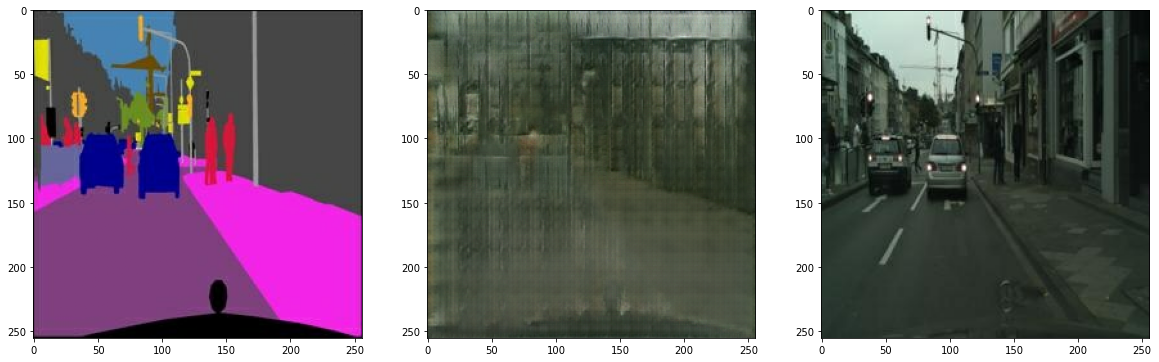

In [32]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch/255.0, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(sketch/255.0)
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(colored/255.0)

데이터의 양이 적어서인지 결과가 좋아보이진 않는다.